In [31]:
import json
import os
from collections import defaultdict
from Models.FeatureExtraction.EmbeddingNet import EmbeddingNet
from Utilities.Confs.Configs import Configs
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
from Data.Datasets.CombinedDataset import CombinedDataset, load_hierarchical_dataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import pytorch_lightning as pl
from sklearn import decomposition
from Utilities.Plots.data_generation import compute_embeddings, compute_shift_matrix, \
    compact_sublcasses
from Utilities.Plots.plots import plot_distance_matrix, plot_embeddings

In [32]:
title = "training-embedding"
configs = Configs("config.yaml", title)

Configs:
Debug root folder: /path/to/visual-pdf-classifier/Debug/training-embedding/1648204713.9399114
{
    "global": {
        "debug": {
            "path": "./Debug/"
        },
        "providers": {
            "contagio": {
                "benign_folder": "folder",
                "malicious_folder": "folder",
                "path": "/path/to/storage"
            },
            "handmade": {
                "benign_categories": [],
                "malicious_categories": [
                    "chrome",
                    "wkhtmltopdf"
                ],
                "path": "/path/to/storage"
            },
            "phishing": {
                "file_storage": "/path/to/storage",
                "postgres": {
                    "database": "pipeline",
                    "host": "127.0.0.1",
                    "password": "password",
                    "port": 5432,
                    "user": "user"
                },
                "screenshot_storage": "/path/to

In [33]:
# HYPER-PARAMETERS
n_epochs = 50
batch_size = 64
test_sampler = False

In [34]:
from Data.SampleProcessors.BaseSampleProcessor import BaseSampleProcessor

# Instantiate the sample processor
sample_processor = BaseSampleProcessor(256,3)

# Instantiate the model
model = EmbeddingNet(3,64,0.3,3)

In [35]:
phishing_data = load_hierarchical_dataset("/path/to/",sample_processor,"sub-category-name")

# save a snapshot of the dataset used for training
with open(os.path.join(configs.debug_root,"dataset.json"), "w") as outfile:
    json.dump(phishing_data.dict_categories_samples, outfile,sort_keys=True)

/path/to/malicious/Amazonscam
/path/to/malicious/ASPDFFile7ViewDocumentNow
/path/to/malicious/ROBLOXGENERATORTextOnly
/path/to/malicious/Ebook3
/path/to/malicious/QRcode
/path/to/malicious/RobloxGeneratorPicture2
/path/to/malicious/EmailApple
/path/to/malicious/AmericanExpress
/path/to/malicious/reCAPTCHADrive
/path/to/malicious/ASPDFFile11AdobepdfElement
/path/to/malicious/Lukoil Card
/path/to/malicious/GetYourFilesWeTransfer
/path/to/malicious/ClickHereTShirt
/path/to/malicious/Ebook5
/path/to/malicious/Ebook8
/path/to/malicious/ASPDFFileExcel
/path/to/malicious/reCAPTCHA
/path/to/malicious/PlayVideo
/path/to/malicious/NSFWFindmebynick
/path/to/malicious/SigueLeyendo
/path/to/malicious/Lotteryform
/path/to/malicious/ASPDFFile10
/path/to/malicious/Applereceipts
/path/to/malicious/NSFWClickthepicture
/path/to/malicious/Ebook6
/path/to/malicious/Ebook12
/path/to/malicious/RussianForum
/path/to/malicious/DownloadPDFBlurred
/path/to/malicious/TryYourLuckPressRussian
/path/to/malicious/Ebo

In [36]:
phishing_training_dataset, phishing_validation_dataset, phishing_test_datasets = phishing_data.compute_splits(n_test_samples=0,n_validation_samples=16,min_training_elements=32)

print(len(phishing_training_dataset))

7879


In [37]:
# be sure that training validation and test sets do not overlap
for element in phishing_training_dataset.samples:

    if element in phishing_validation_dataset.samples:
        raise ValueError

    if element in phishing_test_datasets.samples:
        raise ValueError

print("ALL OK")

ALL OK


In [38]:
from Data.Samplers.ClassSampler import SubclassSampler

n_classes = len(phishing_training_dataset.sub_categories)

# Instantiate training sampler and dataloader
training_sampler = SubclassSampler(phishing_training_dataset,n_classes*24,classes_in_batch=n_classes)
training_dataloader = DataLoader(phishing_training_dataset, pin_memory=True, num_workers=32,batch_sampler=training_sampler)

# Instantiate validation sampler and dataloader
validation_sampler = WeightedRandomSampler(phishing_validation_dataset.class_independent_weights,len(phishing_validation_dataset),replacement=True)
validation_dataloader = DataLoader(phishing_validation_dataset, pin_memory=True, num_workers=8, batch_size=128)

# To plot fair measures and graphs clam every subclass in the test dataset
phishing_test_datasets = phishing_test_datasets.clamp_subclasses(0,20)

In [39]:
print("TRAINING DATASET:")
print(phishing_training_dataset)

print("VALIDATION DATASET")


print(phishing_validation_dataset)

print("TEST DATASET")
print(phishing_test_datasets)

TRAINING DATASET:
MALICIOUS DATASETS: 7879
 
 robloxgeneratortextonly: 2983
 recaptchadrive: 225
 ebook5: 68
 ebook8: 57
 recaptcha: 905
 nsfwfindmebynick: 95
 ebook6: 44
 russianforum: 43
 tryyourluckpressrussian: 39
 ebook7: 55
 nsfwplaybutton: 171
 robloxgeneratorpicture: 263
 ebook9: 216
 lukoil: 285
 clickhere: 234
 downloadtorrentgdriverussian: 57
 generatorbuttonclickhere: 109
 ebook2: 83
 ebook4: 108
 weirdnonsensecrawlertrap: 1800
 accessonlinegenerator: 39

VALIDATION DATASET
MALICIOUS DATASETS: 336
 
 robloxgeneratortextonly: 16
 recaptchadrive: 16
 ebook5: 16
 ebook8: 16
 recaptcha: 16
 nsfwfindmebynick: 16
 ebook6: 16
 russianforum: 16
 tryyourluckpressrussian: 16
 ebook7: 16
 nsfwplaybutton: 16
 robloxgeneratorpicture: 16
 ebook9: 16
 lukoil: 16
 clickhere: 16
 downloadtorrentgdriverussian: 16
 generatorbuttonclickhere: 16
 ebook2: 16
 ebook4: 16
 weirdnonsensecrawlertrap: 16
 accessonlinegenerator: 16

TEST DATASET
MALICIOUS DATASETS: 372
 
 amazonscam: 6
 aspdffile7view

In [40]:
# Test the fairness of the training sampler
if test_sampler:
    subclass_dict = defaultdict(lambda :0)
    c = 0

    for i in validation_sampler:
        sample,class_name,subclass_name,n  = phishing_validation_dataset.get_item_class_subclass(i)
        subclass_dict[subclass_name] +=1

        if c>3000:
            break

        c +=1

    for key,count in subclass_dict.items():
        print(key,count)

In [41]:
# Test an entire epoch of the dataloader to be sure the sampling og the data is fair
from collections import Counter
import pprint



if test_sampler:
    epoch_counter = defaultdict(lambda :0)
    # Test dataloader
    for i, data in enumerate(training_dataloader, 0):

        batch_counter = Counter(data[1])

        for key,count in batch_counter.items():
            epoch_counter[key] += count

    pprint.pprint(epoch_counter)

In [42]:
#Print a sample foreach class to verify the correct labelling
from matplotlib import pyplot as plt
if test_sampler:

    seen_classes = []
    # Test dataloader
    for i, data in enumerate(training_dataloader, 0):

        for i,label in enumerate(data[1]):

            if label not in seen_classes:
                seen_classes.append(label)
                print(label)
                plt.imshow(data[0][i].permute(1, 2, 0),cmap='gray', vmin=0, vmax=1)
                plt.show()

In [43]:
# create folder to store the checkpoints
checkpoints_path = configs.create_debug_folder("checkpoints")
early_stop_callback = EarlyStopping(monitor="validation_loss", patience=10,min_delta=0.05, verbose=True,mode="min")

model_checkpoint = ModelCheckpoint(monitor="validation_loss",dirpath=f"{checkpoints_path}",filename="checkpoint-{epoch:02d}-{validation_loss:.2f}",save_top_k=1,mode="min",save_last=True)

# define trainer
trainer = pl.Trainer(gpus=1, default_root_dir=configs.debug_root, max_epochs=n_epochs, callbacks=[early_stop_callback,model_checkpoint],log_every_n_steps=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [44]:
trainer.fit(model, train_dataloader=training_dataloader, val_dataloaders=validation_dataloader)

best_weights_path = trainer.checkpoint_callback.best_model_path
print("Best checkpoint:",best_weights_path)

last_checkpoint = os.path.join(checkpoints_path,"last.ckpt")
print("Last epoch checkpoint:",last_checkpoint)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type              | Params
------------------------------------------------------------
0 | down_blocks           | Sequential        | 256 K 
1 | final_fully_connected | Sequential        | 266 K 
2 | loss                  | OnlineTripletLoss | 0     
------------------------------------------------------------
523 K     Trainable params
0         Non-trainable params
523 K     Total params
2.094     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
OSError: [Errno 9] Bad file descriptor
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/co

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 19.362


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 8.394 >= min_delta = 0.05. New best score: 10.968


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 4.925 >= min_delta = 0.05. New best score: 6.042


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 3.355 >= min_delta = 0.05. New best score: 2.687


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 1.000 >= min_delta = 0.05. New best score: 1.688


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.203 >= min_delta = 0.05. New best score: 1.484


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.096 >= min_delta = 0.05. New best score: 1.388


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.167 >= min_delta = 0.05. New best score: 1.221


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.144 >= min_delta = 0.05. New best score: 1.077


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.120 >= min_delta = 0.05. New best score: 0.958


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 10 records. Best score: 0.958. Signaling Trainer to stop.


Best checkpoint: /path/to/visual-pdf-classifier/Debug/training-embedding/1648204713.9399114/checkpoints/checkpoint-epoch=12-validation_loss=0.95.ckpt
Last epoch checkpoint: /path/to/visual-pdf-classifier/Debug/training-embedding/1648204713.9399114/checkpoints/last.ckpt


In [45]:
model = EmbeddingNet.load_from_checkpoint(checkpoint_path=best_weights_path)

In [46]:
#Compute the embeddings of a big chunk of training elements
dataset_training_reduced = phishing_training_dataset.clamp_subclasses(0,500)
sample_processor = BaseSampleProcessor(128,3,(1,1),False)
dataset_training_reduced = CombinedDataset(dataset_training_reduced.dataset,sample_processor,label_rule="sub-category-name")
dataloader_training_reduced = DataLoader(dataset_training_reduced,pin_memory=True, num_workers=20, batch_size=batch_size)
embeddings_train_reduced = compute_embeddings(model,dataloader_training_reduced)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:43<00:00,  1.32it/s]


In [47]:
# Compute the centroids of the classes to evaluate their distance ad homogeneity
shift_matrix_training_reduced = compute_shift_matrix(embeddings_train_reduced)

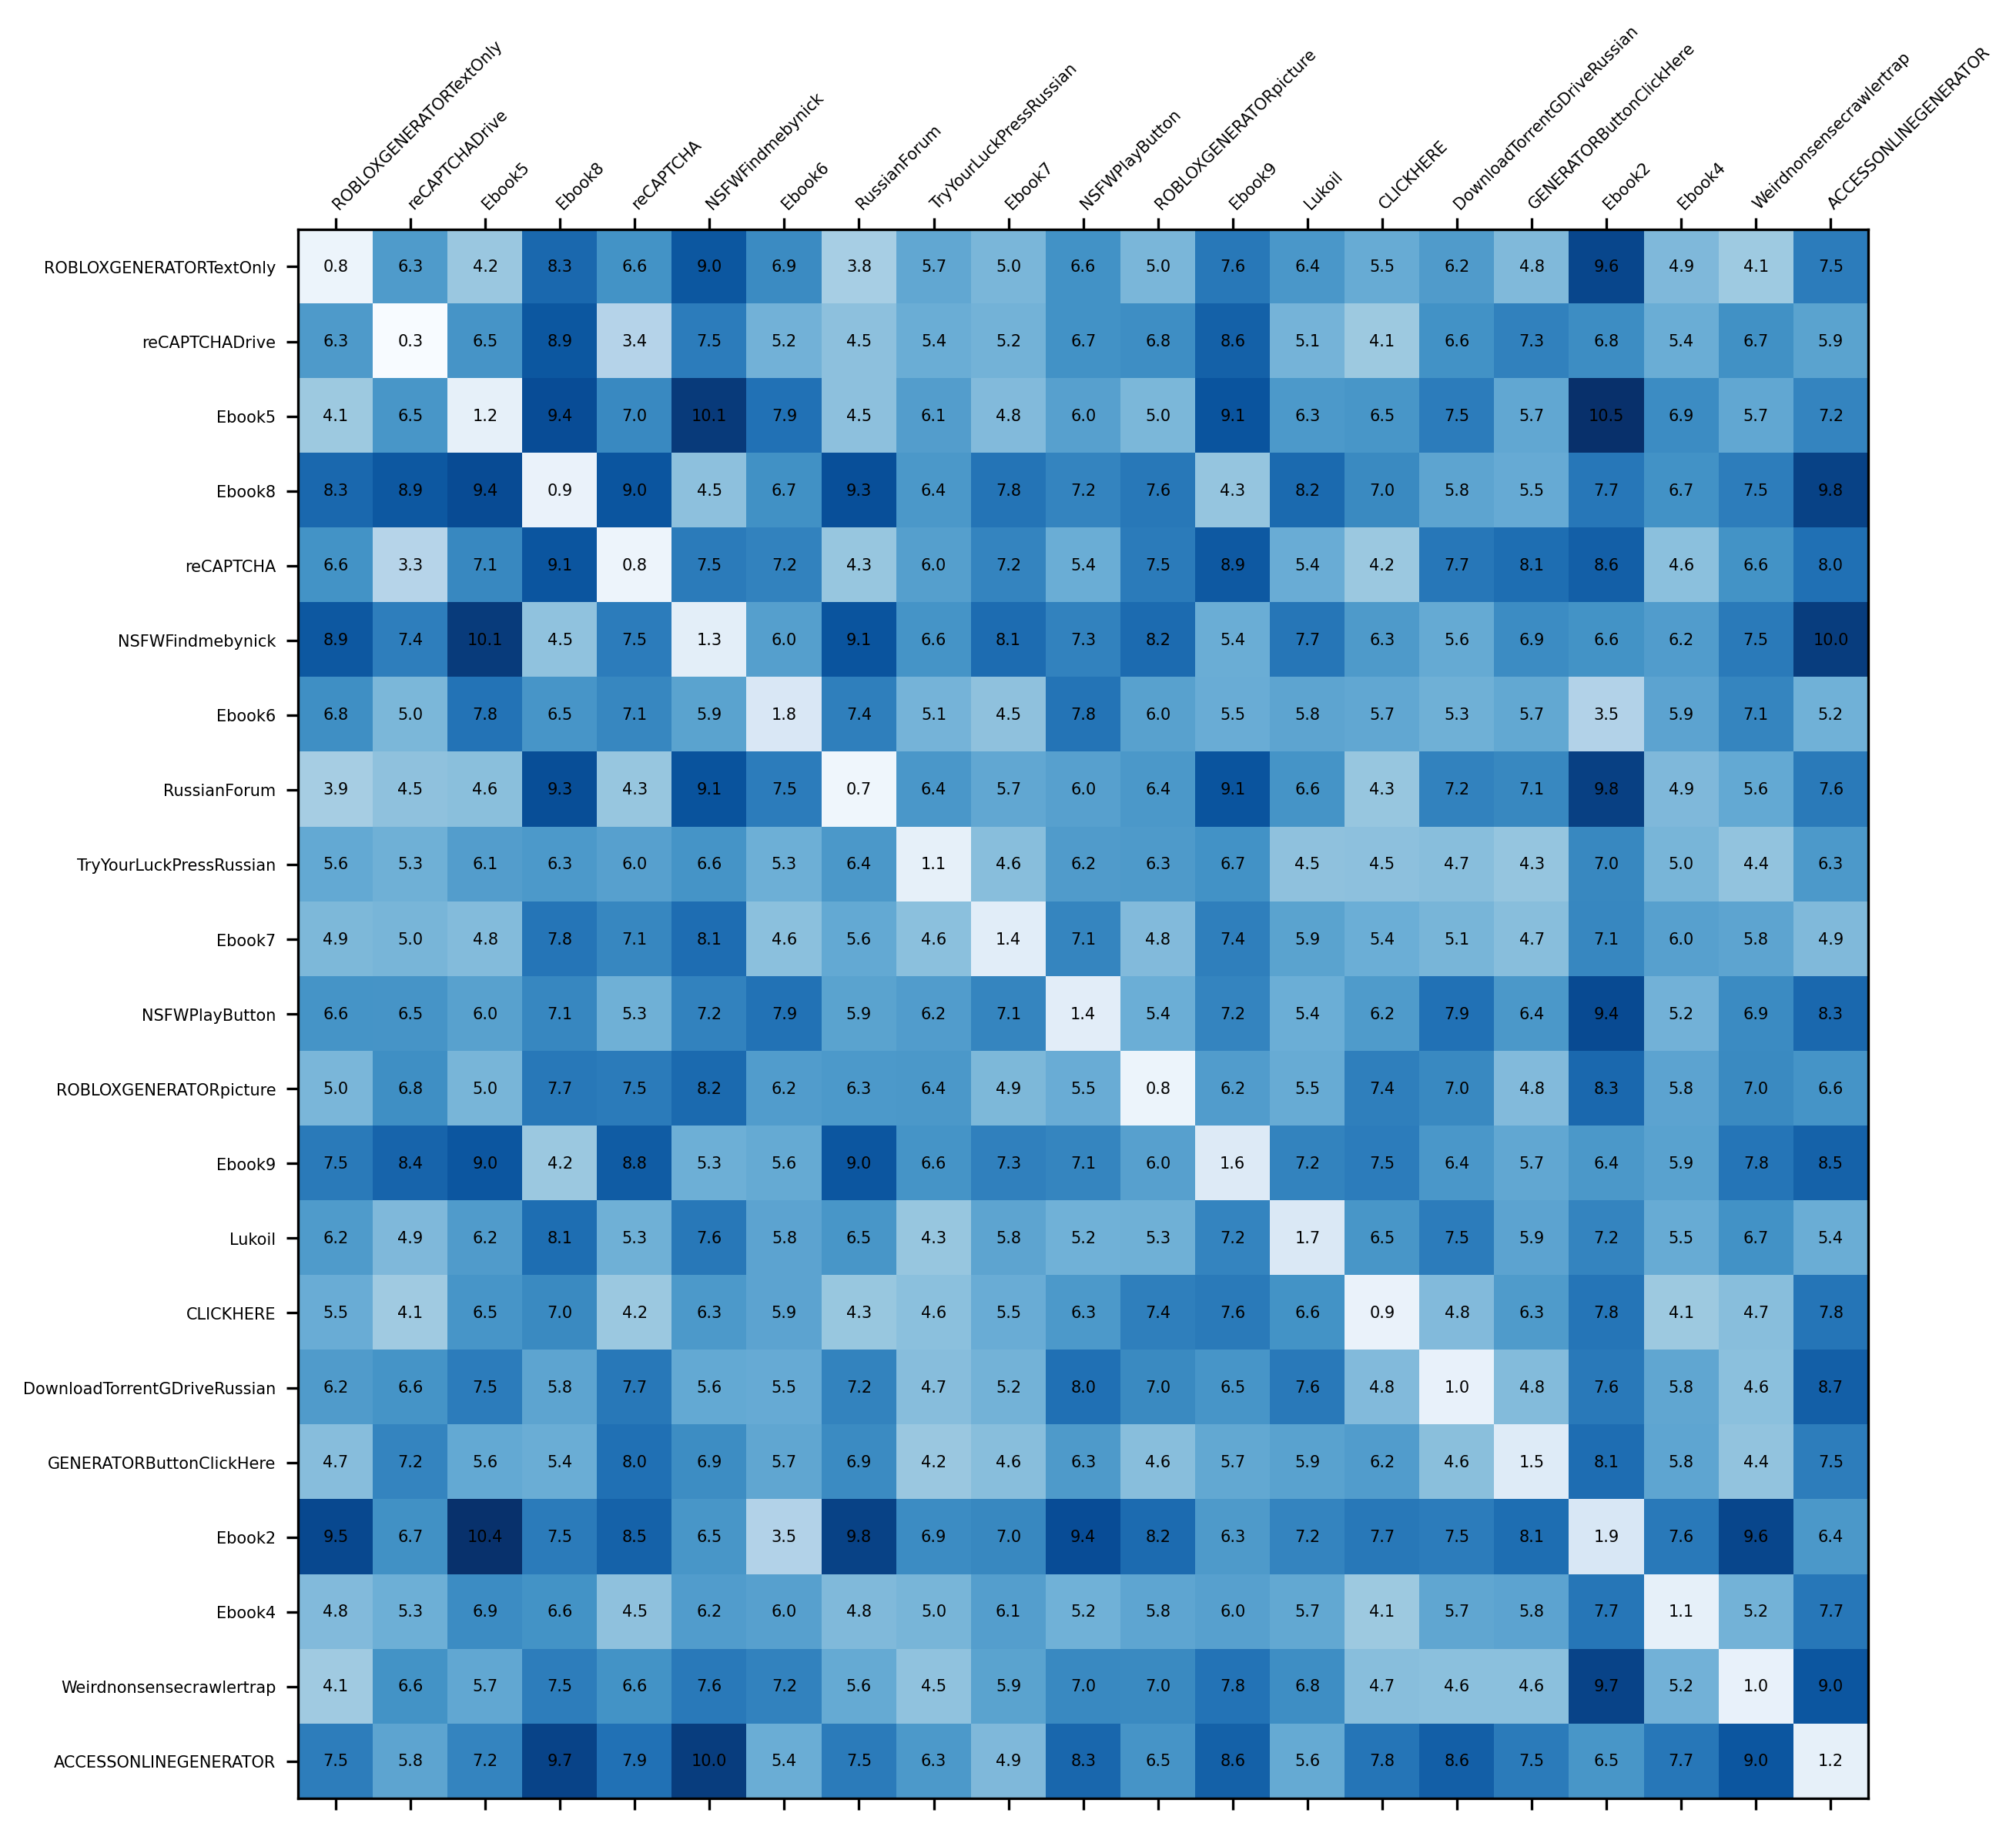

In [48]:
plot_distance_matrix(shift_matrix_training_reduced,embeddings_train_reduced.keys(),path=os.path.join(configs.debug_root,"training-distances.jpeg"))

In [49]:
#Compute the embeddings of a small chuck of the training data to plot them
dataset_training_2_plot = phishing_training_dataset.clamp_subclasses(100,100)
dataset_2_plot_training = CombinedDataset(dataset_training_2_plot.dataset,sample_processor,label_rule="sub-category-name")
plot_dataloader_training = DataLoader(dataset_2_plot_training,pin_memory=True, num_workers=20, batch_size=batch_size)
embeddings_training_2_plot = compute_embeddings(model,plot_dataloader_training)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:23<00:00,  1.31s/it]


In [50]:
# Reduce the dimensionality of the data to plot
pca = decomposition.PCA(n_components=2)
pca.fit(compact_sublcasses(embeddings_train_reduced))

embeddings_training_2_plot_2 = {}
for subclass,data in embeddings_training_2_plot.items():
    embeddings_training_2_plot_2[subclass] = pca.transform(data)

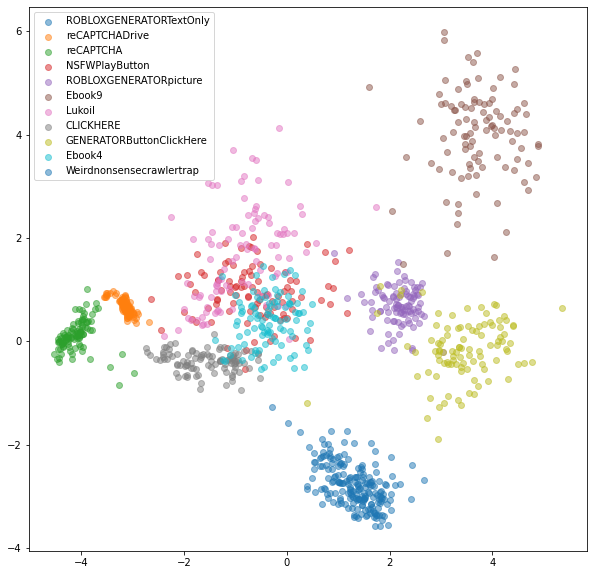

In [51]:
plot_embeddings(embeddings_training_2_plot_2)